In [24]:
import fastf1 as ff1
from fastf1 import plotting

import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm

import numpy as np

In [25]:
ff1.Cache.enable_cache('Cache') 

pd.options.mode.chained_assignment = None

In [26]:
event = 'R'
year = 2023
gp = 'Brazil'

In [27]:
session = ff1.get_session(year, gp, event)

In [28]:
laps = session.load_laps()

c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:1220: FutureWarning: `Session.load_laps` is deprecated and will beremoved in a future version.
Use `Session.load` instead.
  warnings.warn("`Session.load_laps` is deprecated and will be"
core           INFO 	Loading data for São Paulo Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:1492: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for key, value in row.iteritems():
c:\Users\larsl\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1

In [29]:
laps['LapTimeSeconds'] = laps['LapTime'].dt.total_seconds()

laps = laps.loc[(laps['PitOutTime'].isnull() & laps['PitInTime'].isnull())]

In [30]:
q75, q25 = laps['LapTimeSeconds'].quantile(0.75), laps['LapTimeSeconds'].quantile(0.25)

intr_qr = q75 - q25

laptime_max = q75 + (1.5 * intr_qr)
laptime_min = q25 - (1.5 * intr_qr)

laps.loc[laps['LapTimeSeconds'] < laptime_min, 'LapTimeSeconds'] = np.nan
laps.loc[laps['LapTimeSeconds'] > laptime_max, 'LapTimeSeconds'] = np.nan

In [31]:
drivers_to_visualize = ['VER', 'NOR', 'ALO', 'PER']

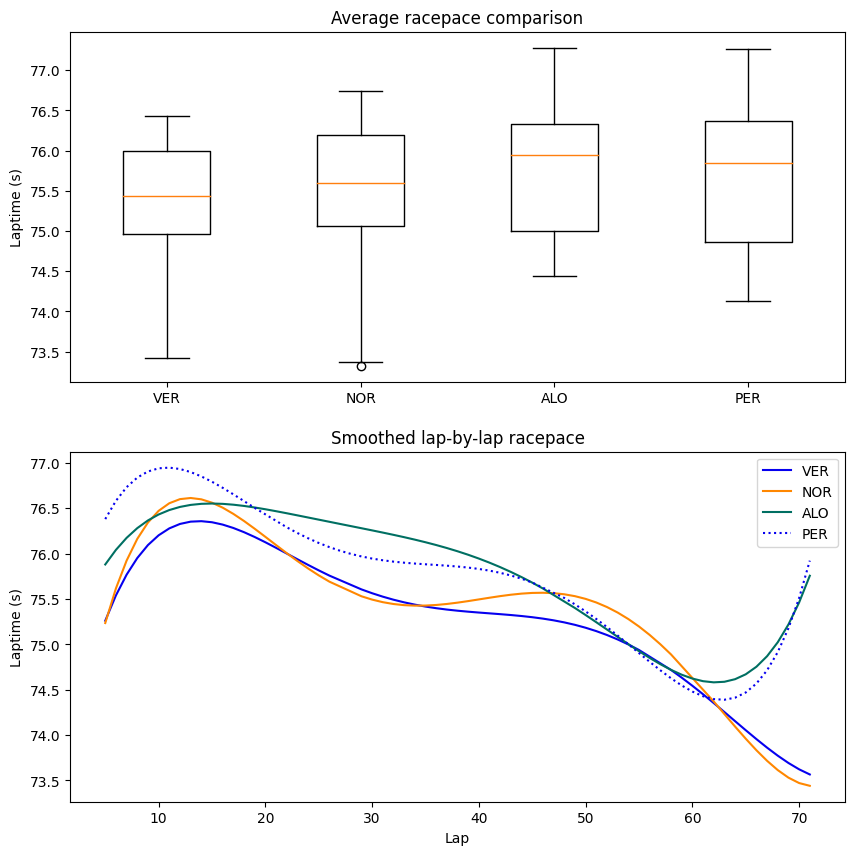

In [32]:
visualized_teams = []

title = f'{str(event)} - Top 4 race pace comparison {str(year)} {str(gp)} Grand Prix'

plt.rcParams['figure.figsize'] = [10, 10]

fig, ax = plt.subplots(2)

laptimes = [laps.pick_driver(x)['LapTimeSeconds'].dropna() for x in drivers_to_visualize] 

ax[0].boxplot(laptimes, labels=drivers_to_visualize)

ax[0].set_title('Average racepace comparison')
ax[0].set(ylabel = 'Laptime (s)')

for driver in drivers_to_visualize:
    driver_laps = laps.pick_driver(driver)[['LapNumber', 'LapTimeSeconds', 'Team']]
    
    driver_laps = driver_laps.dropna()
    
    team = pd.unique(driver_laps['Team'])[0]
    
    x = driver_laps['LapNumber']
    
    poly = np.polyfit(driver_laps['LapNumber'], driver_laps['LapTimeSeconds'], 5)
    y_poly = np.poly1d(poly)(driver_laps['LapNumber'])
    
    linestyle = '-' if team not in visualized_teams else ':'
    
    ax[1].plot(x, y_poly, label=driver, color=ff1.plotting.team_color(team), linestyle=linestyle)
    
    ax[1].set(ylabel = 'Laptime (s)')
    ax[1].set(xlabel = 'Lap')
    
    ax[1].set_title('Smoothed lap-by-lap racepace')

    ax[1].legend()
    
    visualized_teams.append(team)
    
    plt.savefig(f'Figures/{title}', dpi=300)